# Testing the noncontextual projection Ansatz for CS-VQE

We take the base Ansatz for projection to be UCCSD and observe the resuting CS-VQE errors

In [1]:
from symred.build_model import build_molecule_for_projection
from symred.utils import exact_gs_energy, quasi_model
from quantumtools import VariationalAlgorithm
import json
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from itertools import combinations, product
import openfermion as of
import openfermionpyscf as ofpyscf
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
print(molecule_geometries.keys())

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'B_STO-3G_DOUBLET', 'N_STO-3G_QUARTET', 'OH-_STO-3G_SINGLET', 'O_STO-3G_TRIPLET', 'CH2_STO-3G_TRIPLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_TRIPLET', 'NH_STO-3G_SINGLET', 'Ne_STO-3G_SINGLET', 'F_STO-3G_DOUBLET', 'Li_STO-3G_DOUBLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2+_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'H4_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CH3CN_STO-3G_SINGLET', 'CH3CHO_STO-3G_SINGLET', 'CH3CHOHCH3_STO-3G_SINGLET', 'CHONH2_STO-3G_SINGLET', 'CO2_STO-3G_SINGLET', 'O2_STO-3G_SINGLET', 'O3_STO-3G_SINGLET', 'HO

# Build the molecule and CS-VQE model

In [3]:
# Set molecule parameters
speciesname = 'Be_STO-3G_SINGLET'
mol_data = molecule_geometries[speciesname]
if 'name' in mol_data:
    print(mol_data['name'])
    
atoms = mol_data['atoms']
coords = mol_data['coords']
basis = mol_data['basis']
multiplicity = mol_data['multiplicity']
charge = mol_data['charge']
geometry = list(zip(atoms, coords))

delete_input = True
delete_output = True
cisd=1
ccsd=1
fci =1 # wouldn't advise turning this on over 32 qubits!

# Run pyscf.
molecule_data = of.MolecularData(geometry, basis, multiplicity, charge)
calculated_molecule = ofpyscf.run_pyscf(molecule_data,
                     run_scf=1,run_mp2=1,run_cisd=cisd,run_ccsd=ccsd,run_fci=fci)
model = build_molecule_for_projection(calculated_molecule, basis_weighting='ham_coeff')

------------------------------------------------
Information concerning the full system:
------------------------------------------------
Number of qubits in full problem: 10
The Hartree-Fock state is |1111000000>
HF   energy = -14.35188048
MP2  energy = -14.37623885
CISD energy = -14.40364578
CCSD energy = -14.40365075
FCI energy  = -14.40365511
------------------------------------------------
Tapering information:
------------------------------------------------
We are able to taper 5 qubits from the Hamiltonian
The symmetry sector is:
1 ZIZIIZIZIZ +
1 IZIZIZIZIZ +
1 IIIIZZIIII +
1 IIIIIIZZII +
1 IIIIIIIIZZ
The tapered Hartree-Fock state is |11000>
------------------------------------------------
CS-VQE information:
------------------------------------------------
Noncontextual GS energy: -14.352558957524035
Symmetry generators:    
1 IIIIZ +
1 IIIZI +
1 IIZII +
-1 ZIZZZ
Clique representatives: 
-0.9997423322 IZZZZ +
-0.0226995442 IXIII
-----------------------------------------------

In [4]:
num_sim_q = 3
stab_indices = model.greedy_search(num_sim_q)
projected = model.contextual_subspace_projection(stab_indices)
nrg = exact_gs_energy(projected.to_sparse_matrix)[0]
error = abs(nrg-model.fci_energy)
print(f'{projected.n_qubits}-qubit CS-VQE error: {error: .6f} | stabilizer indices: {stab_indices}')

1-qubit CS-VQE error:  0.031615
2-qubit CS-VQE error:  0.015027
3-qubit CS-VQE error:  0.001190
------ done ------
3-qubit CS-VQE error:  0.001190 | stabilizer indices: [0, 4]


# Run a VQE simulation over the contextual subspace

In [5]:
ham_cs = model.contextual_subspace_projection(stab_indices)
ucc_cs = model.contextual_subspace_projection(stab_indices, aux_operator=model.ucc_tap)
ref_cs = model.hf_tapered[model.free_qubit_indices]

vqe = VariationalAlgorithm(ham_cs, ucc_cs, ref_cs)

In [6]:
opt_out, interim = vqe.VQE(optimizer='BFGS', exact=True, maxiter=10)#, n_shots=2**16, n_realize=1)
print('CS-VQE noncontextual projection Ansatz error:', opt_out['fun'] - model.fci_energy)

CS-VQE noncontextual projection Ansatz error: 0.001192063846929159


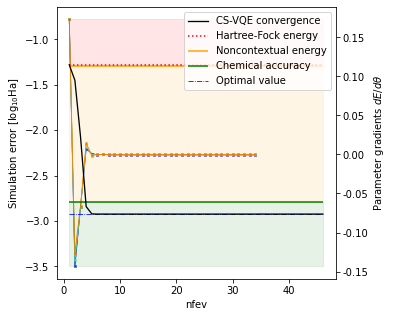

In [7]:
from matplotlib.ticker import FormatStrFormatter

fig,axis = plt.subplots(figsize = (5,5))#, sharex=True, gridspec_kw={'height_ratios': [2, 1]})
#fig.tight_layout()

def transform(dataset, ref_val=0):
    return np.log10(abs(dataset-ref_val))

truegs = model.fci_energy
target = transform(opt_out['fun'], truegs)

X, Y = zip(*interim['values'])
X = np.array(X)
Y = np.array(Y)
Y_error = transform(Y, truegs)
Y_max = np.max(Y_error)+0.5

nfev      = X[-1]
noncon    = transform(model.noncontextual_energy, truegs)
hf_energy = transform(model.hf_energy, truegs)
chemacc   = transform(0.0016)
axis.plot(X, Y_error, label='CS-VQE convergence', color='black', zorder=4, lw=1.3)

axis.hlines(hf_energy, 1, nfev, color='red',ls=':',label='Hartree-Fock energy', zorder=3)
axis.hlines(noncon, 1, nfev, color='orange', label='Noncontextual energy', zorder=2)
axis.hlines(chemacc, 1, nfev, color='green', label='Chemical accuracy', zorder=2)
axis.hlines(target, 1, nfev, color='blue', label='Optimal value', ls='-.', lw=0.8, zorder=3)

axis.fill_between(X, -3.5,np.log10(0.0016), color='green', alpha=0.1, zorder=1)
axis.fill_between(X, np.log10(0.0016), np.log10(model.noncontextual_energy- truegs), color='orange', alpha=0.1, zorder=1)
axis.fill_between(X, np.log10(model.noncontextual_energy- truegs),Y_max, color='red', alpha=0.1, zorder=1)

axis.set_xlabel('nfev')#, fontname=font)    
axis.set_ylabel('Simulation error [$\mathrm{log}_{10}\mathrm{Ha}$]', fontsize=10)#,fontname = font)
#axis.set_xticks(np.arange(1, X_max, 5))
axis.set_yticks(np.arange(-3.5, Y_max, 0.5))
axis.legend()

axis_grad = axis.twinx()
X_grad, Y_grad_list = zip(*interim['gradients'])
for index, Y_grad in enumerate(zip(*Y_grad_list)):
    Y_grad = np.array(Y_grad)
    c = plt.cm.jet(index/(len(Y_grad_list[0])))
    axis_grad.plot(X_grad, Y_grad, color=c, lw=0.8, alpha=0.7, marker='x', ms=2)

axis_grad.set_ylabel('Parameter gradients $dE/d\\theta$', fontsize=10)#,fontname = font)
axis_grad.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#axis_grad.set_ylim(-1,1)
axis.set_zorder(axis_grad.get_zorder()+1)
axis.set_frame_on(False)


# Try to find a more compact Ansatz from the terms of ucc_cs:

In [8]:
ansatz=[]
used_indices = []
for t in range(1,6):
    trials = []
    for i in set(range(ucc_cs.n_terms)).difference(used_indices):
        anz_op_list = [ucc_cs[i]]+ansatz
        anz_op = reduce(lambda x,y:x+y, anz_op_list)
        vqe = VariationalAlgorithm(ham_cs, anz_op, ref_cs)
        min_val, interim = vqe.VQE(init_params=anz_op.coeff_vec.imag, 
                                   optimizer='BFGS', 
                                   maxiter=10, 
                                   exact=True,
                                   opt_tol=1e-10)
        trials.append((i, anz_op, abs(min_val['fun']-model.fci_energy)))   
    best_index, best_term, best_error = sorted(trials, key=lambda x:x[2])[0]
    used_indices.append(best_index)
    ansatz.append(best_term)
    ansatz_op = reduce(lambda x,y:x+y, ansatz)
    print(f'Best {ansatz_op.n_terms}-term Ansatz has an error of {best_error: .8f}:')
    print(ansatz_op)
    print()

Best 1-term Ansatz has an error of  0.03161485:
0.0000000000-0.0984641071j YII

Best 2-term Ansatz has an error of  0.01643272:
0.0000000000-0.0984641071j ZZY +
0.0000000000-0.1969282143j YII

Best 3-term Ansatz has an error of  0.00568006:
0.0000000000-0.1969282143j ZZY +
0.0000000000-0.0984641071j ZYZ +
0.0000000000-0.3938564286j YII

Best 4-term Ansatz has an error of  0.00416677:
0.0000000000-0.3938564286j ZZY +
0.0000000000-0.0984641071j IYI +
0.0000000000-0.1969282143j ZYZ +
0.0000000000-0.7877128572j YII

Best 5-term Ansatz has an error of  0.00143011:
0.0000000000-0.7877128572j ZZY +
0.0000000000-0.1969282143j IYI +
0.0000000000-0.3938564286j ZYZ +
0.0000000000-1.5754257143j YII +
0.0000000000-0.0984641071j YZZ

